# Text classification improving via GAN

**colab-to-git setting**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
GIT_USERNAME = 'VirtualRoyalty'
GIT_REPOSITORY = 'gan-text-classification'

In [3]:
%cd /content/drive/MyDrive/course-paper-2021/gan-text-classification

/content/drive/MyDrive/course-paper-2021/gan-text-classification


In [ ]:
GIT_BRANCH =  'main'
!git branch
!git checkout {GIT_BRANCH}
!git pull origin {GIT_BRANCH}
!git status
print('**OK**')

In [22]:
%%capture
from IPython.display import clear_output
!pip install neptune-client
!pip install -r requirements.txt
clear_output(wait=True)
# !pip freeze | grep transformers

In [5]:
# !pip install neptune-client
import os
import gc
import sys
import json
import numpy as np
import pandas as pd
import importlib as imp
import neptune.new as neptune
from tqdm import tqdm, tqdm_notebook
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

import torch
import torch.nn.functional as F
warnings.simplefilter('ignore')
sys.path.append('..')
# sys.path.append('gan-text-classification')
secret = json.load(open('neptune_token.json'))

# Data Loading

In [65]:
DATASET_NAME = 'yahoo' #'qc' # '20ng', 'qc', 'sst', 'goemotions' 'imdb'
train_path = f"../data/{DATASET_NAME}/train.csv"
test_path = f"../data/{DATASET_NAME}/test.csv"


if DATASET_NAME == 'qc':
    train_df = pd.read_csv(train_path, encoding='utf-8')[['text', 'label']]
    test_df = pd.read_csv(test_path, encoding='utf-8')[['text', 'label']]
if DATASET_NAME == 'yahoo':
    train_df = pd.read_csv(train_path, encoding='utf-8')[['text', 'label']]
    test_df = pd.read_csv(test_path, encoding='utf-8')[['text', 'label']]
elif DATASET_NAME == 'imdb':
    train_df = pd.read_csv(train_path, encoding='utf-8')[['text', 'label']]
    test_df = pd.read_csv(test_path, encoding='utf-8')[['text', 'label']]
elif DATASET_NAME == '20ng':
    train_df = pd.read_csv(train_path, encoding='utf-8')[['clean_text', 'label_name']]
    train_df = train_df.rename(columns={'label_name': 'label', 'clean_text': 'text'})
    test_df = pd.read_csv(test_path, encoding='utf-8')[['text', 'label_name']]
    test_df = test_df.rename(columns={'label_name': 'label', 'clean_text': 'text'})
elif DATASET_NAME == 'sst':
    train_df = pd.read_csv(train_path, encoding='utf-8', sep='\t', header=None, names=['label', 'text'])[['text', 'label']]
    test_df = pd.read_csv(test_path, encoding='utf-8', sep='\t', header=None, names=['label', 'text'])[['text', 'label']]
elif DATASET_NAME == 'goemotions':
    labels = open(f'../data/{DATASET_NAME}/labels.txt', 'r').read().split('\n')
    train_df = pd.read_csv(train_path, sep=',', encoding='utf-8')[['text', 'label']]
    # train_df = train_df.label.apply(lambda x: labels[int(x)])
    test_df = pd.read_csv(test_path, sep=',', encoding='utf-8')[['text', 'label']]
    # test_df = test_df.label.apply(lambda x: labels[int(x)])

print(f'Original  size: {len(train_df) + len(test_df)}')
print(f'Original train size: {len(train_df)}')
print(f'Original test size: {len(test_df)}')
print(f'Num of labels (train): {train_df.label.nunique()}')
print(f'Num of labels (test): {test_df.label.nunique()}')
print(f'\nNum of words (train) stats:')
train_df.text.str.split().apply(len).describe()

Original  size: 35000
Original train size: 25000
Original test size: 10000
Num of labels (train): 10
Num of labels (test): 10

Num of words (train) stats:


count    25000.000000
mean        32.353080
std         37.101668
min          1.000000
25%         11.000000
50%         19.000000
75%         40.000000
max        706.000000
Name: text, dtype: float64

# Run Experiments

In [66]:
import sys
try:
    del sys.modules['experiment']
    del sys.modules['trainer.gan_trainer']
    del sys.modules['trainer']
except:
    print('pass')
from experiment import Experiment

In [67]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

# model_name = "bert-base-cased"
model_name = 'distilbert-base-uncased'
# model_name = "roberta-base"
#model_name = "albert-base-v2"

SAMPLES_PER_LABEL = 10
LABELED_SIZE = train_df.label.nunique() * SAMPLES_PER_LABEL
# PROPORTION = 0.1
PROPORTION = (LABELED_SIZE) / len(train_df)
print('PROPORTION', PROPORTION)
# UNLABEL_PROPORTION = 1.0
UNLABEL_PROPORTION = min((LABELED_SIZE * 5) / (len(train_df) - LABELED_SIZE), 1.0)
UNLABEL_PROPORTION = min(5000 / (len(train_df) - LABELED_SIZE), 1.0)

print('UNLABEL_PROPORTION', UNLABEL_PROPORTION)


CONFIG = dict(model_name=model_name,
              frozen_backbone=False,
              batch_size=64,
              max_seq_length=64,
              num_hidden_layers_g=1,
              num_hidden_layers_d=1,
              noise_size=100,
              out_dropout_rate=0.2,
              apply_balance=True,
              labeled_proportion=PROPORTION,
              unlabeled_proportion=UNLABEL_PROPORTION,
              learning_rate_discriminator=5e-5,
              learning_rate_generator=5e-5,
              epsilon=1e-8,
              num_train_epochs=5,
              multi_gpu=False,
              apply_scheduler=True,
              warmup_proportion_d=0.1,
              warmup_proportion_g=0.0,
              print_each_n_step=15,
              dataset=DATASET_NAME,
              SEED=73)

CONFIG['discriminator_weight'] = 1.0
CONFIG['generator_weight'] = 1.0
CONFIG['cheat_rate_weight'] = 1.0
CONFIG['feature_sim_weight'] = 1.0
CONFIG['supervised_weight'] = 1.0
CONFIG['unsupervised_weight'] = 1.0

CONFIG['num_hidden_layers_g'] = 1
CONFIG['warmup_proportion_d'] = 0.05
CONFIG['noise_type'] = 'uniform'
CONFIG['noise_range'] = (0, 1)
# CONFIG['GAN'] = True
CONFIG['pretrained_generator'] = False
CONFIG['conditional_generator'] = False
CONFIG['distil_gan'] = False
CONFIG['NDA'] = False
CONFIG['nda_alpha'] = 0.9
CONFIG['MF'] = 1e-4

# exp = Experiment(config=CONFIG, train_df=train_df, test_df=test_df, secret=secret, device=device, tags=['exp_10_4000'])

We will use the GPU: Tesla P100-PCIE-16GB
PROPORTION 0.004
UNLABEL_PROPORTION 0.20080321285140562


### Quality by unlabedled size

In [ ]:
SEED = 7
N_LAUNCH = 1

tags = ['exp', 'unlabeled_size']
exp = Experiment(config=CONFIG, train_df=train_df, test_df=test_df, secret=secret, device=device, tags=tags)
exp.split_data(seed=SEED)
exp.create_dataloaders()

for i in range(N_LAUNCH):
    exp.config['GAN'] = False
    exp.train_only_classifier()


print('\n'*3)
for UNLABELED_COEF in [2, 5, 10, 100]:
    print('LABELED SIZE:', LABELED_SIZE)
    print('UNLABELED_SIZE', LABELED_SIZE * UNLABELED_COEF)
    UNLABELED_PROPORTION = min((LABELED_SIZE * UNLABELED_COEF) / (len(train_df) - LABELED_SIZE), 1.0)
    print('unlabeled_proportion', UNLABELED_PROPORTION)
    CONFIG['unlabeled_proportion'] = UNLABELED_PROPORTION
    exp = Experiment(config=CONFIG, train_df=train_df, test_df=test_df, secret=secret, device=device, tags=tags)
    exp.split_data(seed=SEED)
    exp.create_dataloaders()

    for i in range(N_LAUNCH):
        # GAN
        exp.config['GAN'] = True
        exp.config['NDA'] = False
        exp.config['pretrained_generator'] = False
        exp.config['conditional_generator'] = False
        exp.config['manifold'] = False
        exp.train_gan()
    print('\n'*3)

### Quality by labeled size

In [ ]:
N_LAUNCH = 1

tags = ['exp', 'labeled_size_2']


for SAMPLES_PER_LABEL in tqdm_notebook([10, 20, 50, 100]):

    LABELED_SIZE = min(train_df.label.nunique() * SAMPLES_PER_LABEL, len(train_df))
    PROPORTION = (LABELED_SIZE) / len(train_df)
    UNLABELED_SIZE = 5000
    UNLABELED_PROPORTION = min((UNLABELED_SIZE) / (len(train_df) - LABELED_SIZE), 1.0)    
    CONFIG['labeled_proportion'] = PROPORTION
    CONFIG['unlabeled_proportion'] = UNLABELED_PROPORTION

    print('LABELED SIZE:', LABELED_SIZE)
    print('UNLABELED_SIZE', min(UNLABELED_SIZE, len(train_df)))

    exp = Experiment(config=CONFIG, train_df=train_df, test_df=test_df, secret=secret, device=device, tags=tags)
    exp.split_data(seed=CONFIG['SEED'])
    exp.create_dataloaders()

    for i in tqdm_notebook(range(N_LAUNCH), leave=False):
        
        # BERT
        exp.config['GAN'] = False
        exp.train_only_classifier()

        # GAN
        exp.config['GAN'] = True
        exp.config['NDA'] = False
        exp.config['pretrained_generator'] = False
        exp.config['conditional_generator'] = False
        exp.config['manifold'] = False
        exp.train_gan()

        # GAN + NDA 
        exp.config['GAN'] = True
        exp.config['pretrained_generator'] = False
        exp.config['conditional_generator'] = False
        exp.config['NDA'] = True
        exp.config['manifold'] = False
        exp.train_gan()

        # GAN + NDA + manifold
        exp.config['GAN'] = True
        exp.config['pretrained_generator'] = False
        exp.config['conditional_generator'] = False
        exp.config['NDA'] = True
        exp.config['manifold'] = True
        exp.train_gan()

        # GAN + AE pretrain
        exp.config['GAN'] = True
        exp.config['pretrained_generator'] = True
        exp.config['conditional_generator'] = False
        exp.config['NDA'] = False
        exp.config['manifold'] = False
        exp.config['pretrain_gen_num_epochs'] = 5
        exp.train_gan()

        # Conditional-GAN + AE pretrain
        # exp.config['GAN'] = True
        # exp.config['pretrained_generator'] = True
        # exp.config['conditional_generator'] = True
        # exp.config['NDA'] = False
        # exp.config['manifold'] = False
        # exp.config['pretrain_gen_num_epochs'] = 5
        # exp.train_gan()

        # Conditional-GAN + AE pretrain + NDA
        # exp.config['GAN'] = True
        # exp.config['pretrained_generator'] = True
        # exp.config['conditional_generator'] = True
        # exp.config['NDA'] = True
        # exp.config['manifold'] = True
        # exp.config['pretrain_gen_num_epochs'] = 5
        # exp.train_gan()

        # GAN + AE pretrain + manifold
        # exp.config['GAN'] = True
        # exp.config['pretrained_generator'] = True
        # exp.config['conditional_generator'] = False
        # exp.config['NDA'] = False
        # exp.config['manifold'] = True
        # exp.config['pretrain_gen_num_epochs'] = 5
        # exp.train_gan()

        # GAN + AE pretrain + NDA
        exp.config['GAN'] = True
        exp.config['pretrained_generator'] = True
        exp.config['conditional_generator'] = False
        exp.config['NDA'] = True
        exp.config['manifold'] = False
        exp.config['pretrain_gen_num_epochs'] = 5
        exp.train_gan()

 
        # # GAN + AE pretrain + NDA + manifold
        exp.config['GAN'] = True
        exp.config['pretrained_generator'] = True
        exp.config['conditional_generator'] = False
        exp.config['NDA'] = True
        exp.config['manifold'] = True
        exp.config['pretrain_gen_num_epochs'] = 5
        exp.train_gan()



    print('\n'*3)

### Quality by encoder

In [42]:
import time


N_LAUNCH = 1
model_names = [
               "albert-base-v2", 
               "bert-base-cased", 
               "distilbert-base-uncased",
                "distilroberta-base",  

               ]
tags = ['exp', 'base_encoder_5epoch']


model2time = {model_name: [] for model_name in model_names}
for SAMPLES_PER_LABEL in tqdm_notebook([20, 50]):
    LABELED_SIZE = min(train_df.label.nunique() * SAMPLES_PER_LABEL, len(train_df))
    PROPORTION = (LABELED_SIZE) / len(train_df)
    UNLABELED_SIZE = 5000
    UNLABELED_PROPORTION = min((UNLABELED_SIZE) / (len(train_df) - LABELED_SIZE), 1.0)    
    CONFIG['labeled_proportion'] = PROPORTION
    CONFIG['unlabeled_proportion'] = UNLABELED_PROPORTION

    print('LABELED SIZE:', LABELED_SIZE)
    print('UNLABELED_SIZE', min(UNLABELED_SIZE, len(train_df)))
    for model_name in model_names:
        CONFIG['model_name'] = model_name
        exp = Experiment(config=CONFIG, train_df=train_df, test_df=test_df, secret=secret, device=device, tags=tags)
        exp.split_data(seed=CONFIG['SEED'])
        exp.create_dataloaders()

        for i in tqdm_notebook(range(N_LAUNCH), leave=False):
            with torch.no_grad():
                torch.cuda.empty_cache()
            # transformer
            start_time = time.time()
            exp.config['GAN'] = False
            exp.train_only_classifier()
            end_time = time.time() - start_time
            model2time[model_name].append({'GAN': False, 'time': end_time, 'sample_per_label': SAMPLES_PER_LABEL})

            with torch.no_grad():
                torch.cuda.empty_cache()
            # GAN-transformer
            start_time = time.time()
            exp.config['GAN'] = True
            exp.config['NDA'] = False
            exp.config['pretrained_generator'] = False
            exp.config['conditional_generator'] = False
            exp.config['manifold'] = False
            exp.train_gan()
            end_time = time.time() - start_time
            model2time[model_name].append({'GAN': True, 'time': end_time, 'sample_per_label': SAMPLES_PER_LABEL})

  0%|          | 0/2 [00:00<?, ?it/s]

LABELED SIZE: 100
UNLABELED_SIZE 5000
Labeled: 100 Unlabeled: 5000
Label count: 5


  0%|          | 0/1 [00:00<?, ?it/s]

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainable layers 29
https://app.neptune.ai/vmalperovich/gan-text-classification/e/GAN-768
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
======== Epoch 1 / 5 ========
	Average training loss discriminator: 1.669
  Accuracy: 0.231
======== Epoch 2 / 5 ========
	Average training loss discriminator: 1.614
  Accuracy: 0.293
======== Epoch 3 / 5 ========
	Average training loss discriminator: 1.561
  Accuracy: 0.276
======== Epoch 4 / 5 ========
	Average training loss discriminator: 1.531
  Accuracy: 0.262
======== Epoch 5 / 5 ========
	Average training loss discriminator: 1.493
  Accuracy: 0.294
Only classifier
f1_macro 0.151
f1_micro 0.294
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 13 operations to synchronize with Neptune. Do not kill this process.
All 13 operations synced, than

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainable layers 29
https://app.neptune.ai/vmalperovich/gan-text-classification/e/GAN-769
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
======== Epoch 1 / 5 ========
	Average training loss generetor: 3.309
	Average training loss discriminator: 0.324
  Accuracy: 0.318
======== Epoch 2 / 5 ========
	Average training loss generetor: 2.819
	Average training loss discriminator: 0.515
  Accuracy: 0.176
======== Epoch 3 / 5 ========
	Average training loss generetor: 2.471
	Average training loss discriminator: 0.649
  Accuracy: 0.286
======== Epoch 4 / 5 ========
	Average training loss generetor: 2.376
	Average training loss discriminator: 0.721
  Accuracy: 0.286
======== Epoch 5 / 5 ========
	Average training loss generetor: 2.359
	Average training loss discriminator: 0.732
  Accuracy: 0.231
GAN
f1_macro 0.075
f1_micro 0.23

  0%|          | 0/1 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainable layers 203
https://app.neptune.ai/vmalperovich/gan-text-classification/e/GAN-770
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
======== Epoch 1 / 5 ========
	Average training loss discriminator: 1.616
  Accuracy: 0.301
======== Epoch 2 / 5 ========
	Average training loss discriminator: 1.537
  Accuracy: 0.320
======== Epoch 3 / 5 ========
	Average training loss discriminator: 1.432
  Accuracy: 0.276
======== Epoch 4 / 5 ========
	Average training loss discriminator: 1.356
  Accuracy: 0.315
======== Epoch 5 / 5 ========
	Average training loss discriminator: 1.267
  Accuracy: 0.376
Only classifier
f1_macro 0.206
f1_micro 0.376
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 15 operations to synchronize with Neptune. Do not kill this process.
All 15 operations synced, tha

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainable layers 203
https://app.neptune.ai/vmalperovich/gan-text-classification/e/GAN-771
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
======== Epoch 1 / 5 ========
	Average training loss generetor: 2.890
	Average training loss discriminator: 0.269
  Accuracy: 0.315
======== Epoch 2 / 5 ========
	Average training loss generetor: 1.178
	Average training loss discriminator: 0.464
  Accuracy: 0.346
======== Epoch 3 / 5 ========
	Average training loss generetor: 0.830
	Average training loss discriminator: 0.640
  Accuracy: 0.351
======== Epoch 4 / 5 ========
	Average training loss generetor: 0.753
	Average training loss discriminator: 0.693
  Accuracy: 0.338
======== Epoch 5 / 5 ========
	Average training loss generetor: 0.739
	Average training loss discriminator: 0.697
  Accuracy: 0.345
GAN
f1_macro 0.330
f1_micro 0.3

  0%|          | 0/1 [00:00<?, ?it/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainable layers 104
https://app.neptune.ai/vmalperovich/gan-text-classification/e/GAN-772
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
======== Epoch 1 / 5 ========
	Average training loss discriminator: 1.596
  Accuracy: 0.231
======== Epoch 2 / 5 ========
	Average training loss discriminator: 1.596
  Accuracy: 0.231
======== Epoch 3 / 5 ========
	Average training loss discriminator: 1.548
  Accuracy: 0.305
======== Epoch 4 / 5 ========
	Average training loss discriminator: 1.513
  Accuracy: 0.299
======== Epoch 5 / 5 ========
	Average training loss discriminator: 1.404
  Accuracy: 0.324
Only classifier
f1_macro 0.148
f1_micro 0.324
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 15 operations to synchronize with Neptune. Do not kill this process.
All 15 operations synced, tha

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainable layers 104
https://app.neptune.ai/vmalperovich/gan-text-classification/e/GAN-773
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
======== Epoch 1 / 5 ========
	Average training loss generetor: 3.098
	Average training loss discriminator: 0.255
  Accuracy: 0.319
======== Epoch 2 / 5 ========
	Average training loss generetor: 1.291
	Average training loss discriminator: 0.459
  Accuracy: 0.302
======== Epoch 3 / 5 ========
	Average training loss generetor: 0.850
	Average training loss discriminator: 0.637
  Accuracy: 0.312
======== Epoch 4 / 5 ========
	Average training loss generetor: 0.762
	Average training loss discriminator: 0.693
  Accuracy: 0.310
======== Epoch 5 / 5 ========
	Average training loss generetor: 0.745
	Average training loss discriminator: 0.697
  Accuracy: 0.312
GAN
f1_macro 0.286
f1_micro 0.3

  0%|          | 0/1 [00:00<?, ?it/s]

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainable layers 107
https://app.neptune.ai/vmalperovich/gan-text-classification/e/GAN-774
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
======== Epoch 1 / 5 ========
	Average training loss discriminator: 1.613
  Accuracy: 0.262
======== Epoch 2 / 5 ========
	Average training loss discriminator: 1.571
  Accuracy: 0.264
======== Epoch 3 / 5 ========
	Average training loss discriminator: 1.542
  Accuracy: 0.239
======== Epoch 4 / 5 ========
	Average training loss discriminator: 1.555
  Accuracy: 0.241
======== Epoch 5 / 5 ========
	Average training loss discriminator: 1.547
  Accuracy: 0.238
Only classifier
f1_macro 0.106
f1_micro 0.238
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 15 operations to synchronize with Neptune. Do not kill this process.
All 15 operations synced, tha

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainable layers 107
https://app.neptune.ai/vmalperovich/gan-text-classification/e/GAN-775
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
======== Epoch 1 / 5 ========
	Average training loss generetor: 3.398
	Average training loss discriminator: 0.265
  Accuracy: 0.283
======== Epoch 2 / 5 ========
	Average training loss generetor: 2.089
	Average training loss discriminator: 0.498
  Accuracy: 0.362
======== Epoch 3 / 5 ========
	Average training loss generetor: 0.917
	Average training loss discriminator: 0.658
  Accuracy: 0.343
======== Epoch 4 / 5 ========
	Average training loss generetor: 0.762
	Average training loss discriminator: 0.702
  Accuracy: 0.351
======== Epoch 5 / 5 ========
	Average training loss generetor: 0.746
	Average training loss discriminator: 0.703
  Accuracy: 0.340
GAN
f1_macro 0.324
f1_micro 0.3

  0%|          | 0/1 [00:00<?, ?it/s]

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainable layers 29
https://app.neptune.ai/vmalperovich/gan-text-classification/e/GAN-776
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
======== Epoch 1 / 5 ========
	Average training loss discriminator: 1.636
  Accuracy: 0.257
======== Epoch 2 / 5 ========
	Average training loss discriminator: 1.566
  Accuracy: 0.246
======== Epoch 3 / 5 ========
	Average training loss discriminator: 1.501
  Accuracy: 0.383
======== Epoch 4 / 5 ========
	Average training loss discriminator: 1.343
  Accuracy: 0.417
======== Epoch 5 / 5 ========
	Average training loss discriminator: 1.150
  Accuracy: 0.388
Only classifier
f1_macro 0.214
f1_micro 0.388
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 9 operations to synchronize with Neptune. Do not kill this process.
All 9 operations synced, thanks

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainable layers 29
https://app.neptune.ai/vmalperovich/gan-text-classification/e/GAN-777
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
======== Epoch 1 / 5 ========
	Average training loss generetor: 3.206
	Average training loss discriminator: 0.340
  Accuracy: 0.236
======== Epoch 2 / 5 ========
	Average training loss generetor: 2.632
	Average training loss discriminator: 0.545
  Accuracy: 0.276
======== Epoch 3 / 5 ========
	Average training loss generetor: 2.130
	Average training loss discriminator: 0.708
  Accuracy: 0.348
======== Epoch 4 / 5 ========
	Average training loss generetor: 1.545
	Average training loss discriminator: 0.742
  Accuracy: 0.330
======== Epoch 5 / 5 ========
	Average training loss generetor: 1.283
	Average training loss discriminator: 0.749
  Accuracy: 0.337
GAN
f1_macro 0.290
f1_micro 0.33

  0%|          | 0/1 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainable layers 203
https://app.neptune.ai/vmalperovich/gan-text-classification/e/GAN-778
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
======== Epoch 1 / 5 ========
	Average training loss discriminator: 1.601
  Accuracy: 0.321
======== Epoch 2 / 5 ========
	Average training loss discriminator: 1.541
  Accuracy: 0.320
======== Epoch 3 / 5 ========
	Average training loss discriminator: 1.449
  Accuracy: 0.375
======== Epoch 4 / 5 ========
	Average training loss discriminator: 1.250
  Accuracy: 0.397
======== Epoch 5 / 5 ========
	Average training loss discriminator: 0.978
  Accuracy: 0.405
Only classifier
f1_macro 0.290
f1_micro 0.405
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 19 operations to synchronize with Neptune. Do not kill this process.
All 19 operations synced, tha

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainable layers 203
https://app.neptune.ai/vmalperovich/gan-text-classification/e/GAN-779
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
======== Epoch 1 / 5 ========
	Average training loss generetor: 3.042
	Average training loss discriminator: 0.244
  Accuracy: 0.402
======== Epoch 2 / 5 ========
	Average training loss generetor: 1.250
	Average training loss discriminator: 0.452
  Accuracy: 0.394
======== Epoch 3 / 5 ========
	Average training loss generetor: 0.821
	Average training loss discriminator: 0.646
  Accuracy: 0.387
======== Epoch 4 / 5 ========
	Average training loss generetor: 0.750
	Average training loss discriminator: 0.694
  Accuracy: 0.400
======== Epoch 5 / 5 ========
	Average training loss generetor: 0.737
	Average training loss discriminator: 0.697
  Accuracy: 0.389
GAN
f1_macro 0.379
f1_micro 0.3

  0%|          | 0/1 [00:00<?, ?it/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainable layers 104
https://app.neptune.ai/vmalperovich/gan-text-classification/e/GAN-780
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
======== Epoch 1 / 5 ========
	Average training loss discriminator: 1.607
  Accuracy: 0.256
======== Epoch 2 / 5 ========
	Average training loss discriminator: 1.529
  Accuracy: 0.360
======== Epoch 3 / 5 ========
	Average training loss discriminator: 1.440
  Accuracy: 0.389
======== Epoch 4 / 5 ========
	Average training loss discriminator: 1.333
  Accuracy: 0.420
======== Epoch 5 / 5 ========
	Average training loss discriminator: 1.140
  Accuracy: 0.424
Only classifier
f1_macro 0.296
f1_micro 0.424
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 27 operations to synchronize with Neptune. Do not kill this process.
All 27 operations synced, tha

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainable layers 104
https://app.neptune.ai/vmalperovich/gan-text-classification/e/GAN-781
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
======== Epoch 1 / 5 ========
	Average training loss generetor: 2.890
	Average training loss discriminator: 0.315
  Accuracy: 0.380
======== Epoch 2 / 5 ========
	Average training loss generetor: 1.173
	Average training loss discriminator: 0.565
  Accuracy: 0.372
======== Epoch 3 / 5 ========
	Average training loss generetor: 0.785
	Average training loss discriminator: 0.688
  Accuracy: 0.367
======== Epoch 4 / 5 ========
	Average training loss generetor: 0.746
	Average training loss discriminator: 0.698
  Accuracy: 0.365
======== Epoch 5 / 5 ========
	Average training loss generetor: 0.735
	Average training loss discriminator: 0.699
  Accuracy: 0.366
GAN
f1_macro 0.355
f1_micro 0.3

  0%|          | 0/1 [00:00<?, ?it/s]

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainable layers 107
https://app.neptune.ai/vmalperovich/gan-text-classification/e/GAN-782
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
======== Epoch 1 / 5 ========
	Average training loss discriminator: 1.628
  Accuracy: 0.231
======== Epoch 2 / 5 ========
	Average training loss discriminator: 1.578
  Accuracy: 0.259
======== Epoch 3 / 5 ========
	Average training loss discriminator: 1.563
  Accuracy: 0.264
======== Epoch 4 / 5 ========
	Average training loss discriminator: 1.542
  Accuracy: 0.258
======== Epoch 5 / 5 ========
	Average training loss discriminator: 1.534
  Accuracy: 0.265
Only classifier
f1_macro 0.135
f1_micro 0.265
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 27 operations to synchronize with Neptune. Do not kill this process.
All 27 operations synced, tha

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainable layers 107
https://app.neptune.ai/vmalperovich/gan-text-classification/e/GAN-783
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
======== Epoch 1 / 5 ========
	Average training loss generetor: 3.276
	Average training loss discriminator: 0.291
  Accuracy: 0.235
======== Epoch 2 / 5 ========
	Average training loss generetor: 2.292
	Average training loss discriminator: 0.563
  Accuracy: 0.376
======== Epoch 3 / 5 ========
	Average training loss generetor: 1.131
	Average training loss discriminator: 0.704
  Accuracy: 0.367
======== Epoch 4 / 5 ========
	Average training loss generetor: 0.842
	Average training loss discriminator: 0.715
  Accuracy: 0.374
======== Epoch 5 / 5 ========
	Average training loss generetor: 0.754
	Average training loss discriminator: 0.709
  Accuracy: 0.364
GAN
f1_macro 0.354
f1_micro 0.3

---

### Quality by Best models

In [ ]:
N_LAUNCH = 1

tags = ['exp', 'labeled_best']
model_name = "bert-base-cased"

# QC [0.05, 0.1, 0.3, 0.5]
# yahoo [0.01, 0.05, 0.1, 0.3]

for PROPORTION in tqdm_notebook([0.01, 0.05, 0.1, 0.3]):

    LABELED_SIZE = min(len(train_df) * PROPORTION, len(train_df))
    UNLABELED_SIZE = 5000
    UNLABELED_PROPORTION = min((UNLABELED_SIZE) / (len(train_df) - LABELED_SIZE), 1.0)    
    CONFIG['labeled_proportion'] = PROPORTION
    CONFIG['unlabeled_proportion'] = UNLABELED_PROPORTION
    CONFIG['model_name'] = model_name
    print('LABELED SIZE:', LABELED_SIZE)
    print('UNLABELED_SIZE', min(UNLABELED_SIZE, len(train_df)))

    exp = Experiment(config=CONFIG, train_df=train_df, test_df=test_df, secret=secret, device=device, tags=tags)
    exp.split_data(seed=CONFIG['SEED'])
    exp.create_dataloaders()

    for i in tqdm_notebook(range(N_LAUNCH), leave=False):
        
        # BERT
        exp.config['GAN'] = False
        exp.train_only_classifier()

        # GAN
        exp.config['GAN'] = True
        exp.config['NDA'] = False
        exp.config['pretrained_generator'] = False
        exp.config['conditional_generator'] = False
        exp.config['manifold'] = False
        exp.train_gan()


        # GAN + NDA + manifold
        exp.config['GAN'] = True
        exp.config['pretrained_generator'] = False
        exp.config['conditional_generator'] = False
        exp.config['NDA'] = True
        exp.config['manifold'] = True
        exp.train_gan()

        # GAN + AE pretrain
        exp.config['GAN'] = True
        exp.config['pretrained_generator'] = True
        exp.config['conditional_generator'] = False
        exp.config['NDA'] = False
        exp.config['manifold'] = False
        exp.config['pretrain_gen_num_epochs'] = 5
        exp.train_gan()

 
        # GAN + AE pretrain + NDA + manifold
        exp.config['GAN'] = True
        exp.config['pretrained_generator'] = True
        exp.config['conditional_generator'] = False
        exp.config['NDA'] = True
        exp.config['manifold'] = True
        exp.config['pretrain_gen_num_epochs'] = 5
        exp.train_gan()

    print('\n'*3)

  0%|          | 0/4 [00:00<?, ?it/s]

LABELED SIZE: 250.0
UNLABELED_SIZE 5000
Labeled: 250 Unlabeled: 5000
Label count: 10


  0%|          | 0/1 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainable layers 203
https://app.neptune.ai/vmalperovich/gan-text-classification/e/GAN-806
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
======== Epoch 1 / 5 ========
	Average training loss discriminator: 2.310
  Accuracy: 0.191
======== Epoch 2 / 5 ========
	Average training loss discriminator: 2.236
  Accuracy: 0.274
======== Epoch 3 / 5 ========
	Average training loss discriminator: 2.110
  Accuracy: 0.369
======== Epoch 4 / 5 ========
	Average training loss discriminator: 1.875
  Accuracy: 0.502
======== Epoch 5 / 5 ========
	Average training loss discriminator: 1.578
  Accuracy: 0.535
Only classifier
f1_macro 0.509
f1_micro 0.535
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 13 operations to synchronize with Neptune. Do not kill this process.
All 13 operations synced, tha

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainable layers 203
https://app.neptune.ai/vmalperovich/gan-text-classification/e/GAN-807
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
======== Epoch 1 / 5 ========
	Average training loss generetor: 4.096
	Average training loss discriminator: 0.149
  Accuracy: 0.561
======== Epoch 2 / 5 ========
	Average training loss generetor: 1.703
	Average training loss discriminator: 0.312
  Accuracy: 0.569
======== Epoch 3 / 5 ========
	Average training loss generetor: 0.961
	Average training loss discriminator: 0.573
  Accuracy: 0.592
======== Epoch 4 / 5 ========
	Average training loss generetor: 0.779
	Average training loss discriminator: 0.687
  Accuracy: 0.596
======== Epoch 5 / 5 ========
	Average training loss generetor: 0.755
	Average training loss discriminator: 0.696
  Accuracy: 0.598
GAN
f1_macro 0.593
f1_micro 0.5

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainable layers 203
https://app.neptune.ai/vmalperovich/gan-text-classification/e/GAN-808
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
======== Epoch 1 / 5 ========
	Average training loss generetor: 2.814
	Average training loss discriminator: 0.144
  Accuracy: 0.572
======== Epoch 2 / 5 ========
	Average training loss generetor: 1.077
	Average training loss discriminator: 0.247
  Accuracy: 0.603
======== Epoch 3 / 5 ========
	Average training loss generetor: 0.684
	Average training loss discriminator: 0.353
  Accuracy: 0.619
======== Epoch 4 / 5 ========
	Average training loss generetor: 0.606
	Average training loss discriminator: 0.401
  Accuracy: 0.621
======== Epoch 5 / 5 ========
	Average training loss generetor: 0.589
	Average training loss discriminator: 0.408
  Accuracy: 0.620
GAN
f1_macro 0.611
f1_micro 0.6

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start AE pre-training...
epoch [1/5], loss: 0.0629
epoch [2/5], loss: 0.0373
epoch [3/5], loss: 0.0260
epoch [4/5], loss: 0.0177
epoch [5/5], loss: 0.0170
Generator is pretrained
Trainable layers 203
https://app.neptune.ai/vmalperovich/gan-text-classification/e/GAN-809
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
======== Epoch 1 / 5 ========
	Average training loss generetor: 2.412
	Average training loss discriminator: 0.360
  Accuracy: 0.573
======== Epoch 2 / 5 ========
	Average training loss generetor: 0.744
	Average training loss discriminator: 0.432
  Accuracy: 0.591
======== Epoch 3 / 5 ========
	Average training loss generetor: 0.607
	Average training loss discriminator: 0.416
  Accuracy: 0.590
======== Epoch 4 / 5 ========
	Average training loss generetor: 0.593
	Average training loss discriminator: 0.411
  

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start AE pre-training...
epoch [1/5], loss: 0.0580
epoch [2/5], loss: 0.0326
epoch [3/5], loss: 0.0254
epoch [4/5], loss: 0.0214
epoch [5/5], loss: 0.0186
Generator is pretrained
Trainable layers 203
https://app.neptune.ai/vmalperovich/gan-text-classification/e/GAN-810
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
======== Epoch 1 / 5 ========
	Average training loss generetor: 2.435
	Average training loss discriminator: 0.338
  Accuracy: 0.586
======== Epoch 2 / 5 ========
	Average training loss generetor: 0.742
	Average training loss discriminator: 0.430
  Accuracy: 0.592
======== Epoch 3 / 5 ========
	Average training loss generetor: 0.608
	Average training loss discriminator: 0.417
  Accuracy: 0.602
======== Epoch 4 / 5 ========
	Average training loss generetor: 0.593
	Average training loss discriminator: 0.411
  

  0%|          | 0/1 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainable layers 203
https://app.neptune.ai/vmalperovich/gan-text-classification/e/GAN-811
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
======== Epoch 1 / 5 ========
	Average training loss discriminator: 2.196
  Accuracy: 0.522
======== Epoch 2 / 5 ========
	Average training loss discriminator: 1.441
  Accuracy: 0.637
======== Epoch 3 / 5 ========
	Average training loss discriminator: 0.868
  Accuracy: 0.652
======== Epoch 4 / 5 ========
	Average training loss discriminator: 0.519
  Accuracy: 0.652
======== Epoch 5 / 5 ========
	Average training loss discriminator: 0.293
  Accuracy: 0.648
Only classifier
f1_macro 0.645
f1_micro 0.648
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 9 operations to synchronize with Neptune. Do not kill this process.
All 9 operations synced, thank

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainable layers 203
https://app.neptune.ai/vmalperovich/gan-text-classification/e/GAN-812
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
======== Epoch 1 / 5 ========
	Average training loss generetor: 2.714
	Average training loss discriminator: 0.160
  Accuracy: 0.650
======== Epoch 2 / 5 ========
	Average training loss generetor: 1.231
	Average training loss discriminator: 0.309
  Accuracy: 0.645
======== Epoch 3 / 5 ========
	Average training loss generetor: 0.702
	Average training loss discriminator: 0.405
  Accuracy: 0.647
======== Epoch 4 / 5 ========
	Average training loss generetor: 0.615
	Average training loss discriminator: 0.416
  Accuracy: 0.629
======== Epoch 5 / 5 ========
	Average training loss generetor: 0.587
	Average training loss discriminator: 0.415
  Accuracy: 0.652
GAN
f1_macro 0.650
f1_micro 0.6

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainable layers 203
https://app.neptune.ai/vmalperovich/gan-text-classification/e/GAN-813
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
======== Epoch 1 / 5 ========
	Average training loss generetor: 2.799
	Average training loss discriminator: 0.152
  Accuracy: 0.621
======== Epoch 2 / 5 ========
	Average training loss generetor: 1.291
	Average training loss discriminator: 0.287
  Accuracy: 0.614
======== Epoch 3 / 5 ========
	Average training loss generetor: 0.754
	Average training loss discriminator: 0.396
  Accuracy: 0.629
======== Epoch 4 / 5 ========
	Average training loss generetor: 0.622
	Average training loss discriminator: 0.414
  Accuracy: 0.636
======== Epoch 5 / 5 ========
	Average training loss generetor: 0.594
	Average training loss discriminator: 0.414
  Accuracy: 0.648
GAN
f1_macro 0.639
f1_micro 0.6

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start AE pre-training...
epoch [1/5], loss: 0.0620
epoch [2/5], loss: 0.0265
epoch [3/5], loss: 0.0194
epoch [4/5], loss: 0.0151
epoch [5/5], loss: 0.0192
Generator is pretrained
Trainable layers 203
https://app.neptune.ai/vmalperovich/gan-text-classification/e/GAN-814
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
======== Epoch 1 / 5 ========
	Average training loss generetor: 2.272
	Average training loss discriminator: 0.370
  Accuracy: 0.650
======== Epoch 2 / 5 ========
	Average training loss generetor: 1.044
	Average training loss discriminator: 0.426
  Accuracy: 0.626
======== Epoch 3 / 5 ========
	Average training loss generetor: 0.698
	Average training loss discriminator: 0.420
  Accuracy: 0.628
======== Epoch 4 / 5 ========
	Average training loss generetor: 0.606
	Average training loss discriminator: 0.414
  

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start AE pre-training...
epoch [1/5], loss: 0.0508
epoch [2/5], loss: 0.0313
epoch [3/5], loss: 0.0211
epoch [4/5], loss: 0.0134
epoch [5/5], loss: 0.0158
Generator is pretrained
Trainable layers 203
https://app.neptune.ai/vmalperovich/gan-text-classification/e/GAN-815
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
======== Epoch 1 / 5 ========
	Average training loss generetor: 2.313
	Average training loss discriminator: 0.371
  Accuracy: 0.640
======== Epoch 2 / 5 ========
	Average training loss generetor: 1.106
	Average training loss discriminator: 0.423
  Accuracy: 0.643
======== Epoch 3 / 5 ========
	Average training loss generetor: 0.728
	Average training loss discriminator: 0.418
  Accuracy: 0.650
======== Epoch 4 / 5 ========
	Average training loss generetor: 0.610
	Average training loss discriminator: 0.413
  

  0%|          | 0/1 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainable layers 203
https://app.neptune.ai/vmalperovich/gan-text-classification/e/GAN-816
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
======== Epoch 1 / 5 ========
	Average training loss discriminator: 1.977
  Accuracy: 0.627
======== Epoch 2 / 5 ========
	Average training loss discriminator: 1.039
  Accuracy: 0.672
======== Epoch 3 / 5 ========
	Average training loss discriminator: 0.626
  Accuracy: 0.658
======== Epoch 4 / 5 ========
	Average training loss discriminator: 0.421
  Accuracy: 0.664
======== Epoch 5 / 5 ========
	Average training loss discriminator: 0.224
  Accuracy: 0.652
Only classifier
f1_macro 0.656
f1_micro 0.652
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 9 operations to synchronize with Neptune. Do not kill this process.
All 9 operations synced, thank

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainable layers 203
https://app.neptune.ai/vmalperovich/gan-text-classification/e/GAN-817
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
======== Epoch 1 / 5 ========
	Average training loss generetor: 2.821
	Average training loss discriminator: 0.162
  Accuracy: 0.621
======== Epoch 2 / 5 ========
	Average training loss generetor: 1.626
	Average training loss discriminator: 0.314
  Accuracy: 0.670
======== Epoch 3 / 5 ========
	Average training loss generetor: 1.117
	Average training loss discriminator: 0.407
  Accuracy: 0.667
======== Epoch 4 / 5 ========
	Average training loss generetor: 0.872
	Average training loss discriminator: 0.415
  Accuracy: 0.652
======== Epoch 5 / 5 ========
	Average training loss generetor: 0.724
	Average training loss discriminator: 0.417
  Accuracy: 0.650
GAN
f1_macro 0.650
f1_micro 0.6

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainable layers 203
https://app.neptune.ai/vmalperovich/gan-text-classification/e/GAN-818
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
======== Epoch 1 / 5 ========
	Average training loss generetor: 2.836
	Average training loss discriminator: 0.155
  Accuracy: 0.658
======== Epoch 2 / 5 ========
	Average training loss generetor: 1.644
	Average training loss discriminator: 0.286
  Accuracy: 0.659
======== Epoch 3 / 5 ========
	Average training loss generetor: 1.088
	Average training loss discriminator: 0.393
  Accuracy: 0.660
======== Epoch 4 / 5 ========
	Average training loss generetor: 0.830
	Average training loss discriminator: 0.414
  Accuracy: 0.644
======== Epoch 5 / 5 ========
	Average training loss generetor: 0.717
	Average training loss discriminator: 0.416
  Accuracy: 0.641
GAN
f1_macro 0.644
f1_micro 0.6

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start AE pre-training...
epoch [1/5], loss: 0.0562
epoch [2/5], loss: 0.0339
epoch [3/5], loss: 0.0220
epoch [4/5], loss: 0.0262
epoch [5/5], loss: 0.0118
Generator is pretrained
Trainable layers 203
https://app.neptune.ai/vmalperovich/gan-text-classification/e/GAN-819
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
======== Epoch 1 / 5 ========


# Collected statistics

In [48]:
import pandas as pd

In [49]:
URL = 'https://app.neptune.ai/api/leaderboard/v1/download/downloadFile?id=968e8e1d-75bd-4387-a27e-e5b9ea9e96db'
stat_df = pd.read_csv(URL)

## Unlabeled size

In [62]:
df = stat_df[stat_df['Tags'].str.contains('unlabeled_size')]
subset = ['dataset', 'GAN', 'f1_macro (max)', 'f1_micro (max)', 'labeled', 'unlabeled',
          'accuracy (last)']
np.around(df[df.GAN == False][subset].groupby(['dataset', 'unlabeled']).agg(['mean', 'std']), 2)

GAN      f1_macro (max)       f1_micro (max)       labeled  \
                  mean  std           mean   std           mean   std    mean   
dataset unlabeled                                                               
qc      2500.0     0.0  0.0           0.10  0.01           0.51  0.02   500.0   
sst     250.0      0.0  NaN           0.16   NaN           0.30   NaN    50.0   

                       accuracy (last)        
                   std            mean   std  
dataset unlabeled                             
qc      2500.0     0.0            0.51  0.02  
sst     250.0      NaN            0.30   NaN

In [169]:
np.around(df[df.GAN == True][subset].groupby(['dataset', 'unlabeled']).agg(['mean', 'std']), 2)

GAN      f1_macro (max)       f1_micro (max)       labeled  \
                  mean  std           mean   std           mean   std    mean   
dataset unlabeled                                                               
qc      1000       1.0  0.0           0.17  0.01           0.61  0.00   500.0   
        2500       1.0  0.0           0.41  0.02           0.75  0.01   500.0   
        4951       1.0  0.0           0.55  0.02           0.80  0.02   500.0   
sst     100        1.0  0.0           0.12  0.04           0.26  0.04    50.0   
        250        1.0  0.0           0.21  0.00           0.34  0.01    50.0   
        500        1.0  0.0           0.25  0.03           0.32  0.03    50.0   
        5000       1.0  0.0           0.29  0.01           0.32  0.01    50.0   

                       accuracy (last)        
                   std            mean   std  
dataset unlabeled                             
qc      1000       0.0            0.61  0.00  
        2500       0.0            0.75  0.01  
        4951       0.0            0.80  0.02  
sst     100        0.0            0.26  0.04  
        250        0.0            0.34  0.01  
        500        0.0            0.32  0.03  
        5000       0.0            0.32  0.01

## Labeled size

In [198]:
df = stat_df[stat_df['Tags'].str.contains('labeled_size_2')]

def get_name(row):
    _model = row['config/model_name'].replace('-base-uncased', '').replace('-base-cased', '')
    if not row['GAN']:
        return _model
    name = f"GAN-{_model}"
    if row['conditional_gen']:
        name = f"C" + name 
    if row['NDA']:
        name = name + f" + NDA"
    if row['manifold']:
        name = name + f" + MF"
    if row['pretrained_gen']:
        name = name + f" + AE"
    return name

df['NAME'] = df.apply(get_name, axis=1)
df['NAME'].unique()

array(['GAN-distilbert + NDA + MF + AE', 'GAN-distilbert + NDA + AE',
       'GAN-distilbert + AE', 'GAN-distilbert + NDA + MF',
       'GAN-distilbert + NDA', 'GAN-distilbert', 'distilbert'],
      dtype=object)

In [199]:
subset = ['dataset', 'GAN', 'f1_macro (max)', 'f1_micro (max)', 'labeled', 'unlabeled',
          'accuracy (last)']
np.around(df[df.GAN == False].groupby(['dataset', 'NAME'])[subset].agg(['mean', 'std']), 2)

GAN      f1_macro (max)       f1_micro (max)        \
                   mean  std           mean   std           mean   std   
dataset NAME                                                             
20ng    distilbert  0.0  0.0           0.26  0.19           0.30  0.19   
imdb    distilbert  0.0  0.0           0.55  0.06           0.58  0.04   
qc      distilbert  0.0  0.0           0.29  0.21           0.65  0.16   
sst     distilbert  0.0  0.0           0.19  0.05           0.34  0.06   
yahoo   distilbert  0.0  0.0           0.43  0.19           0.47  0.17   

                   labeled          unlabeled          accuracy (last)        
                      mean      std      mean      std            mean   std  
dataset NAME                                                                  
20ng    distilbert   900.0   748.33    5000.0     0.00            0.30  0.19  
imdb    distilbert    90.0    74.83    5000.0     0.00            0.58  0.04  
qc      distilbert  2250.0  1827.82    3201.0  1827.82            0.65  0.16  
sst     distilbert   225.0   187.08    5000.0     0.00            0.34  0.06  
yahoo   distilbert   450.0   404.15    5000.0     0.00            0.47  0.17

In [208]:
# np.around(df[df.GAN == True].groupby(['dataset', 'NAME'])[subset].agg(['mean']), 2)

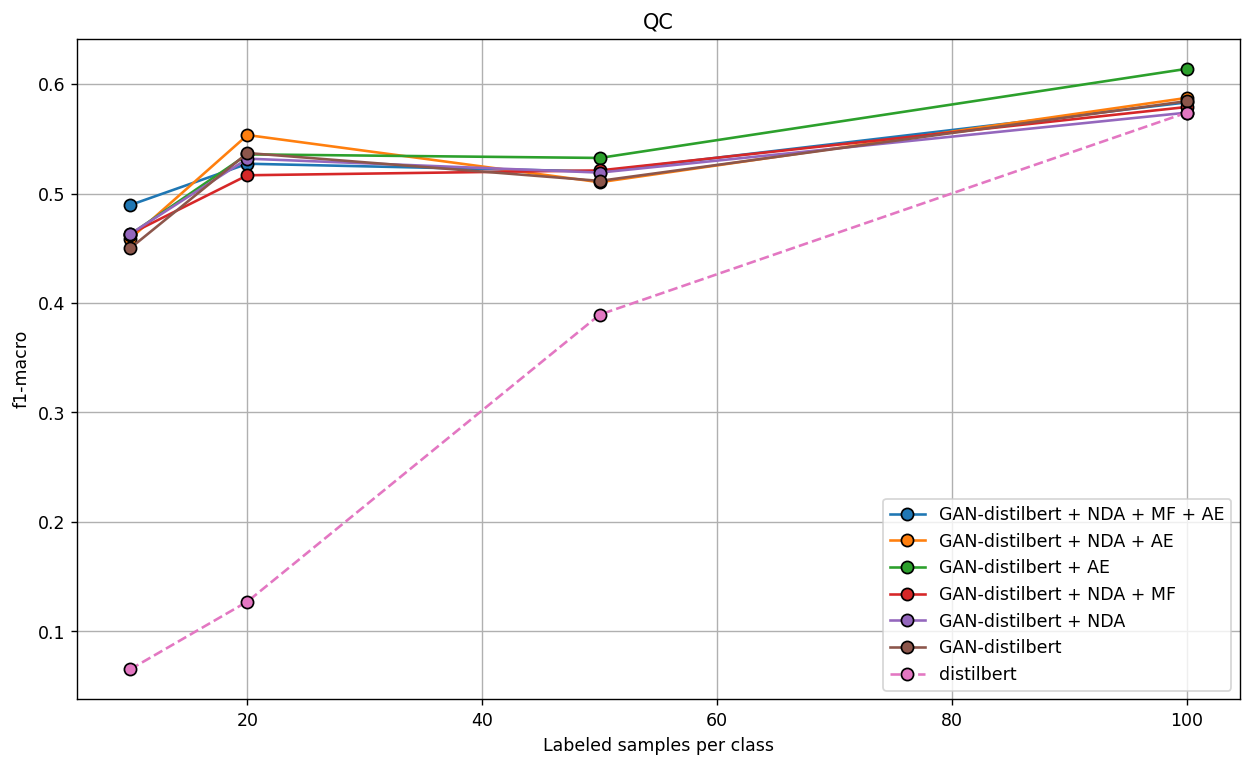

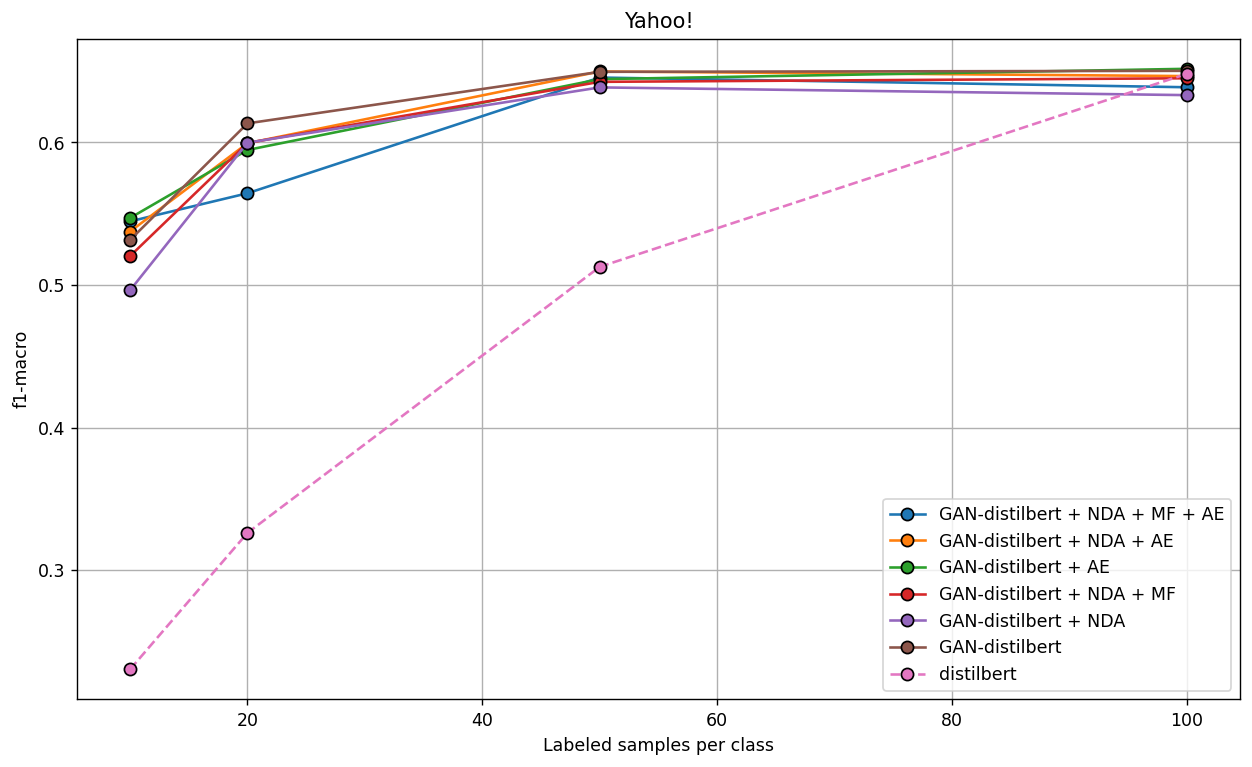

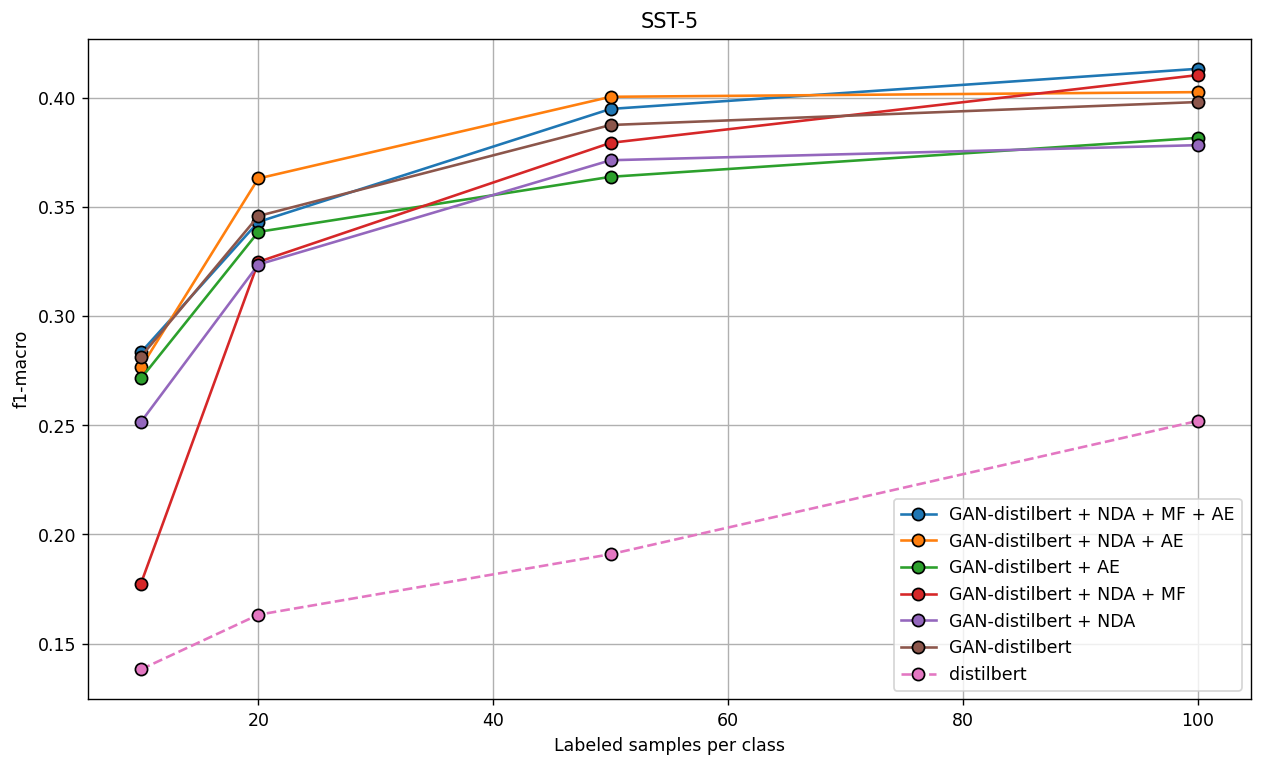

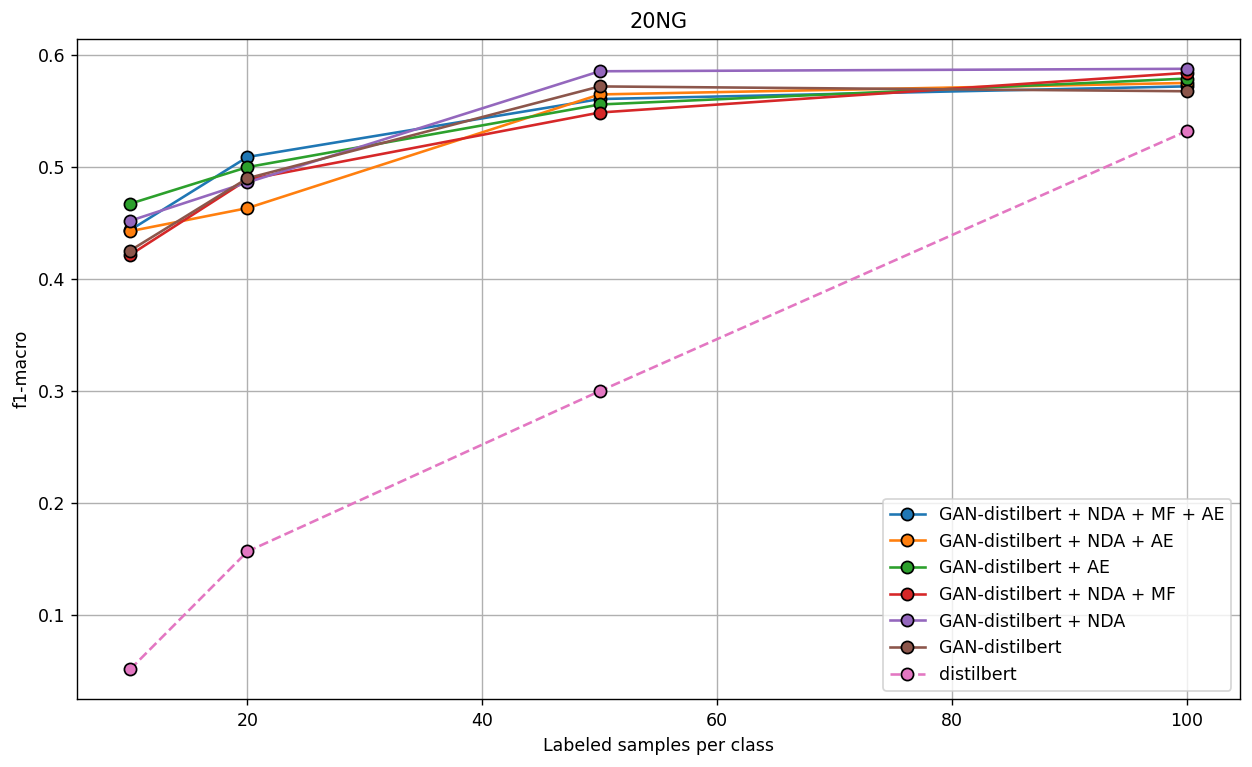

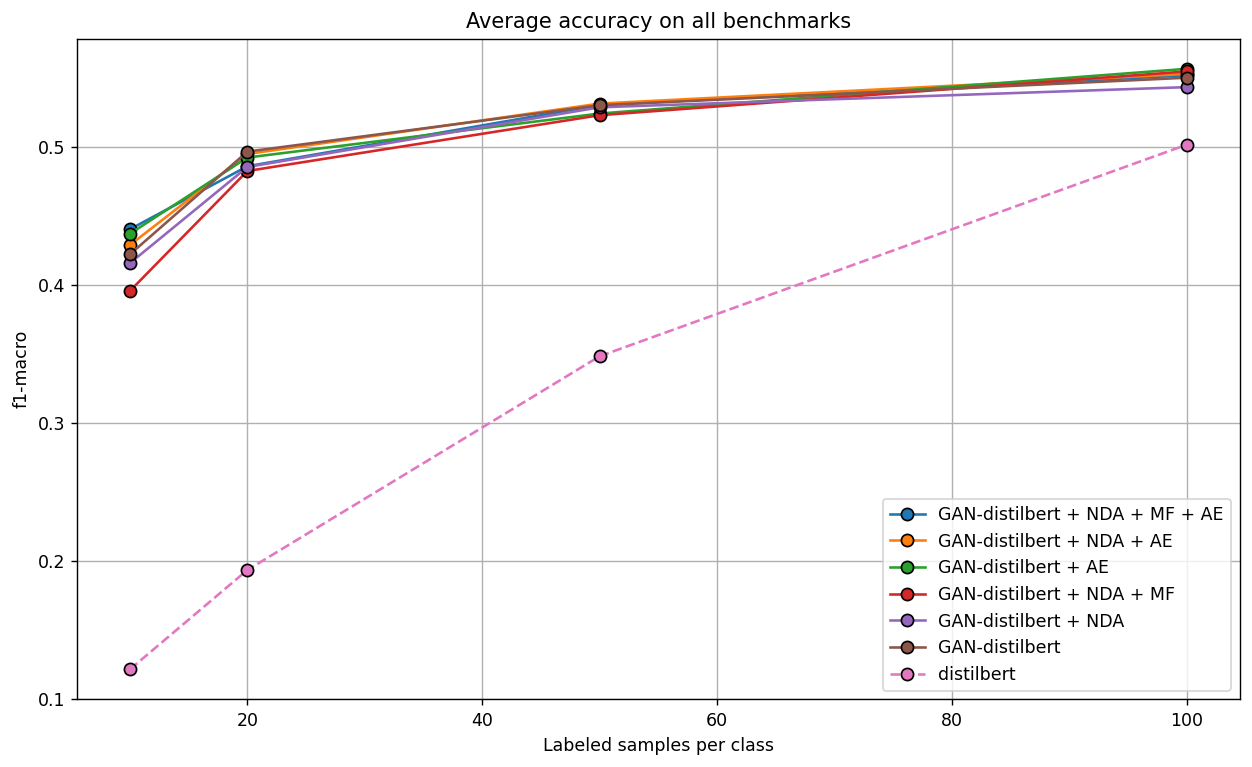

In [217]:
import matplotlib.pyplot as plt


x = [10, 20, 50, 100]
set2name = {'qc': 'QC', 'sst': 'SST-5', 'imdb': 'IMDB', '20ng': '20NG', 'yahoo': 'Yahoo!'}

model2avg_f1 = {name:[] for name in df.NAME.unique()}
for _DATASET_NAME in df.dataset.unique():
    if _DATASET_NAME == 'imdb':
        continue
    tmp_df = df[df.dataset == _DATASET_NAME]
    avg_macro = []
    for avg in ['macro']:#, 'micro']:
        plt.figure(figsize=(12, 7), dpi=125)
        for NAME in df.NAME.unique():
            macro = tmp_df[tmp_df['NAME'] == NAME].groupby(['labeled']).agg({f'f1_{avg} (max)': 'mean'}) #.sort_values(['labeled'])
            model2avg_f1[NAME].append(macro)
            plt.plot(x, macro, marker='o' , label=NAME, linestyle=('--' if NAME == 'distilbert' else '-'), markersize=7, markeredgecolor='black')

        plt.legend()
        plt.ylabel(f'f1-{avg}')
        plt.xlabel('Labeled samples per class')
        plt.title(f'{set2name[_DATASET_NAME]}')
        plt.grid()

plt.figure(figsize=(12, 7), dpi=125)
for NAME in df.NAME.unique():
    macro = np.array(model2avg_f1[NAME]).mean(axis=0)
    plt.plot(x, macro, marker='o' , label=NAME, linestyle=('--' if NAME == 'distilbert' else '-'), markersize=7, markeredgecolor='black')
plt.legend()
plt.ylabel(f'f1-{avg}')
plt.xlabel('Labeled samples per class')
plt.title(f'Average accuracy on all benchmarks')
plt.grid()


In [ ]:
3

## Encoder quality

In [40]:
df = stat_df[stat_df['Tags'].str.contains('base_encoder')]
subset = ['dataset', 'GAN', 'f1_macro (max)', 'f1_micro (max)',
          'accuracy (last)']
np.around(df.groupby(['dataset', 'config/model_name', 'labeled', 'GAN'])[subset].agg(['mean']), 2)

GAN f1_macro (max)  \
                                              mean           mean   
dataset config/model_name       labeled GAN                         
qc      albert-base-v2          1000.0  False  0.0           0.12   
                                        True   1.0           0.43   
                                2500.0  False  0.0           0.37   
                                        True   1.0           0.32   
        bert-base-cased         1000.0  False  0.0           0.18   
                                        True   1.0           0.56   
                                2500.0  False  0.0           0.51   
                                        True   1.0           0.59   
        distilbert-base-uncased 1000.0  False  0.0           0.16   
                                        True   1.0           0.53   
                                2500.0  False  0.0           0.40   
                                        True   1.0           0.54   
        distilroberta-base      1000.0  False  0.0           0.04   
                                        True   1.0           0.23   
                                2500.0  False  0.0           0.20   
                                        True   1.0           0.36   
        roberta-base            1000.0  False  0.0           0.02   
                                        True   1.0           0.02   
                                2500.0  False  0.0           0.10   
                                        True   1.0           0.16   
sst     albert-base-v2          250.0   False  0.0           0.08   
                                        True   1.0           0.30   
                                500.0   False  0.0           0.24   
                                        True   1.0           0.15   
        bert-base-cased         250.0   False  0.0           0.21   
                                        True   1.0           0.36   
                                500.0   False  0.0           0.23   
                                        True   1.0           0.37   
        distilbert-base-uncased 250.0   False  0.0           0.20   
                                        True   1.0           0.35   
                                500.0   False  0.0           0.23   
                                        True   1.0           0.38   
        distilroberta-base      250.0   False  0.0           0.09   
                                        True   1.0           0.32   
                                500.0   False  0.0           0.15   
                                        True   1.0           0.33   

                                              f1_micro (max) accuracy (last)  
                                                        mean            mean  
dataset config/model_name       labeled GAN                                   
qc      albert-base-v2          1000.0  False           0.55            0.55  
                                        True            0.77            0.77  
                                2500.0  False           0.73            0.73  
                                        True            0.70            0.70  
        bert-base-cased         1000.0  False           0.62            0.62  
                                        True            0.81            0.81  
                                2500.0  False           0.81            0.81  
                                        True            0.84            0.84  
        distilbert-base-uncased 1000.0  False           0.61            0.61  
                                        True            0.81            0.81  
                                2500.0  False           0.77            0.77  
                                        True            0.83            0.83  
        distilroberta-base      1000.0  False           0.39            0.39  
                                        True            0.62            0.62  
            

In [33]:
times = pd.DataFrame(model2time)
for col in times:
    times[col] = times[col].apply(lambda x: x['time'])
np.around(times / 60, 1)

,roberta-base,distilroberta-base,albert-base-v2,bert-base-cased,distilbert-base-uncased
0,0.6,0.3,0.4,0.6,0.3
1,3.2,1.7,3.4,3.2,1.7
2,0.9,0.5,0.9,0.9,0.5
3,2.7,1.4,2.9,2.7,1.4


## Best model quality

In [53]:
df = stat_df[stat_df['Tags'].str.contains('labeled_best')]

def get_name(row):
    _model = row['config/model_name'].replace('-base-uncased', '').replace('-base-cased', '')
    if not row['GAN']:
        return _model
    name = f"GAN-{_model}"
    if row['conditional_gen']:
        name = f"C" + name 
    if row['NDA']:
        name = name + f" + NDA"
    if row['manifold']:
        name = name + f" + MF"
    if row['pretrained_gen']:
        name = name + f" + AE"
    return name

df['NAME'] = df.apply(get_name, axis=1)
df['NAME'].unique()

array(['GAN-bert + NDA + MF + AE', 'GAN-bert + AE', 'GAN-bert + NDA + MF',
       'GAN-bert', 'bert'], dtype=object)

In [59]:
subset = ['dataset', 'GAN', 'f1_macro (max)', 'f1_micro (max)', 'labeled', 'unlabeled',
          'accuracy (last)']
np.around(df.groupby(['dataset', 'NAME', 'labeled_proportion'])[subset].agg(['mean', 'std']), 2)

GAN     f1_macro (max)  \
                                                    mean std           mean   
dataset NAME                     labeled_proportion                           
qc      GAN-bert                 0.05                1.0 NaN           0.45   
                                 0.10                1.0 NaN           0.63   
                                 0.30                1.0 NaN           0.64   
                                 0.50                1.0 NaN           0.74   
        GAN-bert + AE            0.05                1.0 NaN           0.50   
                                 0.10                1.0 NaN           0.64   
                                 0.30                1.0 NaN           0.68   
                                 0.50                1.0 NaN           0.79   
        GAN-bert + NDA + MF      0.05                1.0 NaN           0.52   
                                 0.10                1.0 NaN           0.62   
                                 0.30                1.0 NaN           0.66   
                                 0.50                1.0 NaN           0.81   
        GAN-bert + NDA + MF + AE 0.05                1.0 NaN           0.47   
                                 0.10                1.0 NaN           0.63   
                                 0.30                1.0 NaN           0.68   
                                 0.50                1.0 NaN           0.79   
        bert                     0.05                0.0 NaN           0.09   
                                 0.10                0.0 NaN           0.11   
                                 0.30                0.0 NaN           0.50   
                                 0.50                0.0 NaN           0.76   

                                                        f1_micro (max)      \
                                                    std           mean std   
dataset NAME                     labeled_proportion                          
qc      GAN-bert                 0.05               NaN           0.72 NaN   
                                 0.10               NaN           0.82 NaN   
                                 0.30               NaN           0.85 NaN   
                                 0.50               NaN           0.88 NaN   
        GAN-bert + AE            0.05               NaN           0.75 NaN   
                                 0.10               NaN           0.81 NaN   
                                 0.30               NaN           0.85 NaN   
                                 0.50               NaN           0.90 NaN   
        GAN-bert + NDA + MF      0.05               NaN           0.76 NaN   
                                 0.10               NaN           0.80 NaN   
                                 0.30               NaN           0.86 NaN   
                                 0.50               NaN           0.89 NaN   
        GAN-bert + NDA + MF + AE 0.05               NaN           0.75 NaN   
                                 0.10               NaN           0.80 NaN   
                                 0.30               NaN           0.85 NaN   
                                 0.50               NaN           0.89 NaN   
        bert                     0.05               NaN           0.47 NaN   
                                 0.10               NaN           0.57 NaN   
                                 0.30               NaN           0.80 NaN   
                                 0.50               NaN           0.87 NaN   

                                                    labeled     unlabeled      \
                                                       mean std      mean std   
dataset NAME                     labeled_proportion                             
qc      GAN-bert                 0.05                 272.0 NaN    5001.0 NaN   
                                 0.10                 545.0 NaN    4906.0 NaN   
                                 0.

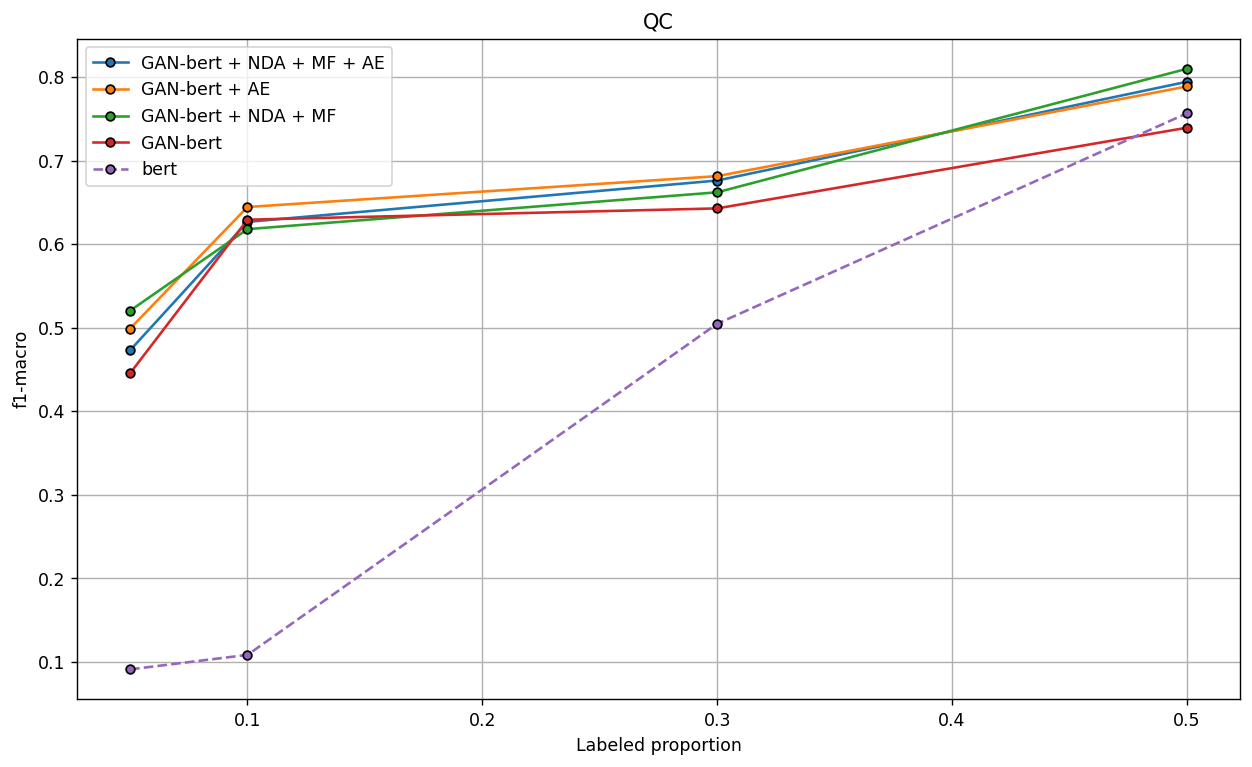

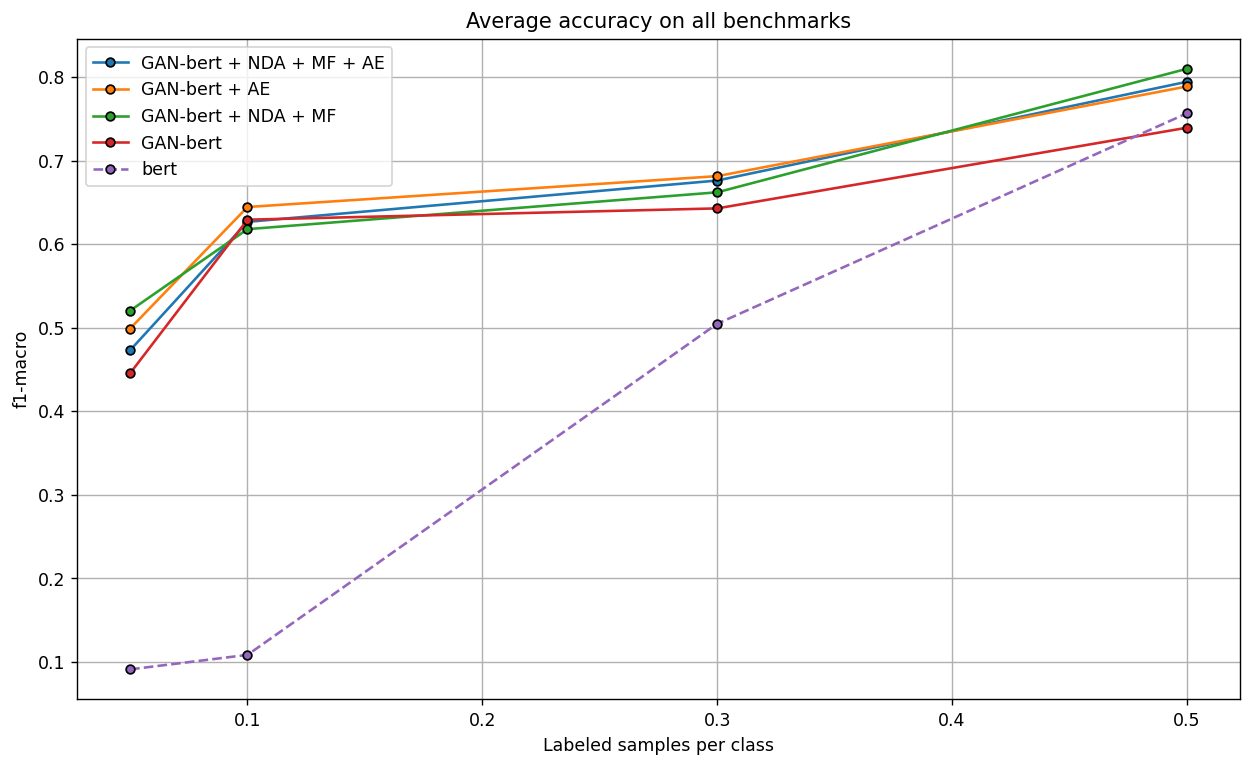

In [63]:
import matplotlib.pyplot as plt


x = [0.05, 0.1, 0.3, 0.5]
set2name = {'qc': 'QC', 'sst': 'SST-5', 'imdb': 'IMDB', '20ng': '20NG', 'yahoo': 'Yahoo!'}

model2avg_f1 = {name:[] for name in df.NAME.unique()}
for _DATASET_NAME in df.dataset.unique():
    if _DATASET_NAME == 'imdb':
        continue
    tmp_df = df[df.dataset == _DATASET_NAME]
    avg_macro = []
    for avg in ['macro']:#, 'micro']:
        plt.figure(figsize=(12, 7), dpi=125)
        for NAME in df.NAME.unique():
            macro = tmp_df[tmp_df['NAME'] == NAME].groupby(['labeled']).agg({f'f1_{avg} (max)': 'mean'}) #.sort_values(['labeled'])
            model2avg_f1[NAME].append(macro)
            plt.plot(x, macro, marker='o' , label=NAME, linestyle=('--' if NAME == 'bert' else '-'), markersize=5, markeredgecolor='black')

        plt.legend()
        plt.ylabel(f'f1-{avg}')
        plt.xlabel('Labeled proportion')
        plt.title(f'{set2name[_DATASET_NAME]}')
        plt.grid()

plt.figure(figsize=(12, 7), dpi=125)
for NAME in df.NAME.unique():
    macro = np.array(model2avg_f1[NAME]).mean(axis=0)
    plt.plot(x, macro, marker='o' , label=NAME, linestyle=('--' if NAME == 'bert' else '-'), markersize=5, markeredgecolor='black')
plt.legend()
plt.ylabel(f'f1-{avg}')
plt.xlabel('Labeled samples per class')
plt.title(f'Average accuracy on all benchmarks')
plt.grid()
